In [1]:
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# load `.mat` file
data = scipy.io.loadmat('face.mat')

# Images
# N: number of images
# D: number of pixels
X = data['X']  # shape: [D x N]
y = data['l']  # shape: [1 x N]

assert(X.shape[1] == y.shape[1])
# Number of images
D, N = X.shape

# Fix the random seed
np.random.seed(13)

# Cardinality of labels
_card = len(set(y.ravel()))

# Step splitting of dataset
_step = int(N / _card)

# Shape boundaries
_bounds = np.arange(0, N+1, _step)

# Shapes
shapes = list(zip(_bounds[:-1], _bounds[1:]))

# Training Mask
_mask = []

for _shape in shapes:
    _idx = np.random.choice(
        np.arange(*_shape), int(0.8 * _step), replace=False)
    _mask.append(_idx)

mask_train = np.array(_mask).ravel()

mask_test = np.array(list(set(np.arange(0, N)) - set(mask_train)))

# Partition dataset to train and test sets
X_train, X_test = X[:, mask_train], X[:, mask_test]
y_train, y_test = y[:, mask_train], y[:, mask_test]

In [14]:
class PCA(object):
    """Principle Component Analysis."""

    def __init__(self, n_comps=5, standard=True):
        """Contructor.
        Parameters
        ----------
        n_comps: int
            Number of principle components
        """
        self._fitted = False
        self.n_comps = n_comps
        self.standard = standard
        self.mean = None
        self.U = None

    def fit(self, X):
        """Fit PCA according to `X.cov()`.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.D, N = X.shape
        self.mean = X.mean(axis=1).reshape(-1, 1)
        # center data
        A = X - self.mean
        # covariance matrix
        S = (1 / N) * np.dot(A.T, A)
        
        _l, _v = np.linalg.eig(S)

        _indexes = np.argsort(_l)[::-1]

        # Sorted eigenvalues and eigenvectors
        l, v = _l[_indexes], _v[:, _indexes]

        V = v[:, :self.n_comps]

        _U = np.dot(A, V)

        self.U = _U / np.apply_along_axis(np.linalg.norm, 0, _U)

        W = np.dot(self.U.T, A)

        if self.standard:
            self.W_mean = np.mean(W, axis=1)
            self.W_std = np.std(W, axis=1)

        self._fitted = True

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def transform(self, X):
        """Transform `X` by projecting it to PCA feature space.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """

        Phi = X - self.mean

        W = np.dot(self.U.T, Phi)

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def reconstruct(self, W):
        """Recontruct compressed data.
        Parameters
        ----------
        W: numpy.ndarray
            Projection coefficients matrix
        Returns
        -------
        X_hat: numpy.ndarray
            Reconstructed features matrix
        """
        A_hat = np.dot(self.U, W).reshape(-1, 1)
        A_hat = A_hat + self.mean
        return A_hat

In [20]:
# KNN Classifer
from sklearn.neighbors import KNeighborsClassifier

M = 1
standard = False
M_train = []
acc_train = []

D, N = X_train.shape

while M < 408:

    pca = PCA(n_comps=M, standard=standard)

    W_train = pca.fit(X_train)

    I, K = X_test.shape

    W_test = pca.transform(X_test)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(W_train.T, y_train.T.ravel())
    acc = nn.score(W_test.T, y_test.T.ravel())
    print('Accuracy = %.2f%%' % (acc * 100))
    acc_train.append(acc*100)
    M_train.append(M)
    M = M + 1

Accuracy = 4.81%
Accuracy = 8.65%
Accuracy = 18.27%
Accuracy = 24.04%
Accuracy = 38.46%
Accuracy = 36.54%
Accuracy = 34.62%
Accuracy = 36.54%
Accuracy = 38.46%
Accuracy = 41.35%
Accuracy = 44.23%
Accuracy = 46.15%
Accuracy = 47.12%
Accuracy = 48.08%
Accuracy = 51.92%
Accuracy = 51.92%
Accuracy = 50.96%
Accuracy = 52.88%
Accuracy = 52.88%
Accuracy = 51.92%
Accuracy = 52.88%
Accuracy = 54.81%
Accuracy = 54.81%
Accuracy = 59.62%
Accuracy = 57.69%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 60.58%
Accuracy = 59.62%
Accuracy = 59.62%
Accuracy = 59.62%
Accuracy = 61.54%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 57.69%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 59.62%
Accuracy = 58.65%
Accuracy = 60.58%
Accuracy = 62.50%
Accuracy = 61.54%
Accuracy = 61.54%
Accuracy = 61.54%
Accuracy = 62.50%
Accuracy = 62.50%
Accuracy = 63.46%
Accuracy = 63.46%
Accuracy = 62.50%
Accuracy = 61.54%
Accuracy = 62.50%
Accuracy = 62.50%
Accuracy = 63.46%
Accuracy = 62.50%
Accuracy = 6

Text(0,0.5,'Recogniton Accuracy / %')

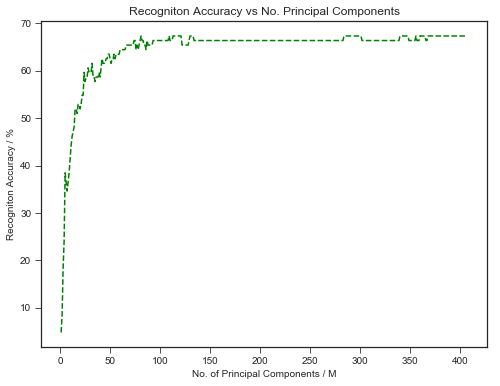

In [21]:
plt.figure(figsize=(8.0, 6.0))
plt.plot(M_train, acc_train, color='green', linestyle='dashed')
plt.title('Recogniton Accuracy vs No. Principal Components')
plt.xlabel('No. of Principal Components / M')
plt.ylabel('Recogniton Accuracy / %')

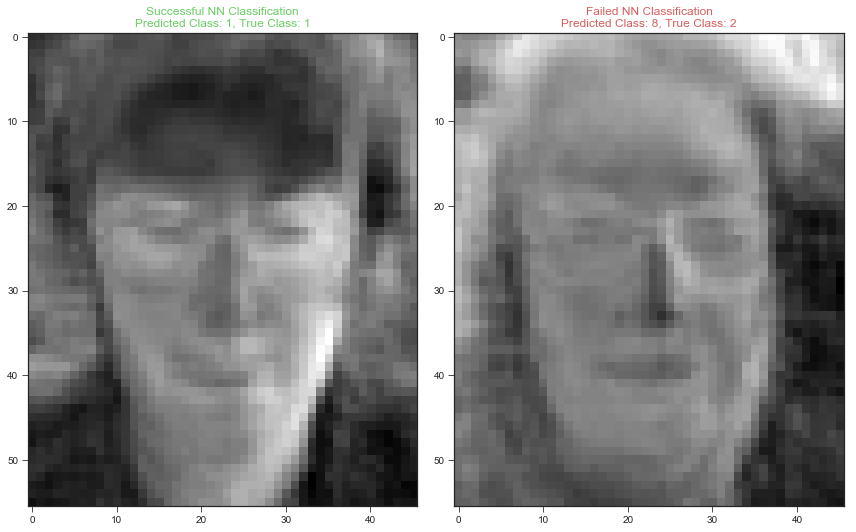

In [29]:
# prettify plots
plt.rcParams['figure.figsize'] = [12.0, 9.0]
sns.set_palette(sns.color_palette("muted"))
_palette = sns.color_palette("muted")
sns.set_style("ticks")


M = 121
standard = False

pca = PCA(n_comps=M, standard=standard)

W_train = pca.fit(X_train)

I, K = X_test.shape

W_test = pca.transform(X_test)

nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(W_train.T, y_train.T.ravel())

y_hat = nn.predict(W_test.T)

done = {'success': False, 'failure': False}

fig, axes = plt.subplots(ncols=2)

for y, t, w in zip(y_hat, y_test.T.ravel(), W_test.T):
    if y == t and done['success'] is False:
        x_hat = pca.reconstruct(w)
        axes[0].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[0].set_title(
            'Successful NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[1])
        done['success'] = True
    elif y != t and done['failure'] is False:
        x_hat = pca.reconstruct(w)
        axes[1].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[1].set_title(
            'Failed NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[2])
        done['failure'] = True
    #elif done['failure'] is True and done['success'] is True:
     #break

fig.tight_layout()

In [50]:
# Alternative Method

from sklearn.metrics import accuracy_score

M = 1
standard = False

D, N = X_train.shape
_step = 8
_card = 52

y_hat = []
rec_err = []

M_ideal = None
acc_max = 0

while M < 408:

    for i in range(_card):
        pca = PCA(n_comps=M, standard=standard)
    
        W_train = pca.fit(X_train[:,_step*i:_step*i+8])
    
        W_test = pca.transform(X_test)
    
        for k, (x, w) in enumerate(zip(X_test.T, W_test.T)):
    
            x_hat = pca.reconstruct(w.reshape(-1,1))
        
            _rec_err = np.linalg.norm(x_hat-(x.reshape(-1,1)))
        
            if len(y_hat) <= k:
                y_hat.append(int(i+1))
                rec_err.append(_rec_err)
            elif _rec_err < rec_err[k]:
                y_hat[k] = int(i+1)
                rec_err[k] = _rec_err

    acc = accuracy_score(y_test.T, y_hat)    
    print('M = ', M,' --->  Accuracy = %.2f%%' % (acc * 100))
    
    
    if (acc > acc_max):
        M_ideal = M
        acc_max = acc
        
    M = M + 1
    
    
print ("Accuracy is maximum for ", M_ideal, " eigenvectors with accuracy of ", acc_max, ".")


M =  1  --->  Accuracy = 59.62%
M =  2  --->  Accuracy = 69.23%
M =  3  --->  Accuracy = 73.08%
M =  4  --->  Accuracy = 77.88%
M =  5  --->  Accuracy = 82.69%
M =  6  --->  Accuracy = 80.77%
M =  7  --->  Accuracy = 80.77%
M =  8  --->  Accuracy = 80.77%
M =  9  --->  Accuracy = 80.77%
M =  10  --->  Accuracy = 80.77%
M =  11  --->  Accuracy = 80.77%
M =  12  --->  Accuracy = 80.77%
M =  13  --->  Accuracy = 80.77%
M =  14  --->  Accuracy = 80.77%
M =  15  --->  Accuracy = 80.77%
M =  16  --->  Accuracy = 80.77%
M =  17  --->  Accuracy = 80.77%
M =  18  --->  Accuracy = 80.77%
M =  19  --->  Accuracy = 80.77%
M =  20  --->  Accuracy = 80.77%
M =  21  --->  Accuracy = 80.77%
M =  22  --->  Accuracy = 80.77%
M =  23  --->  Accuracy = 80.77%
M =  24  --->  Accuracy = 80.77%
M =  25  --->  Accuracy = 80.77%
M =  26  --->  Accuracy = 80.77%
M =  27  --->  Accuracy = 80.77%
M =  28  --->  Accuracy = 80.77%
M =  29  --->  Accuracy = 80.77%
M =  30  --->  Accuracy = 80.77%
M =  31  --->  Accu

M =  246  --->  Accuracy = 80.77%
M =  247  --->  Accuracy = 80.77%
M =  248  --->  Accuracy = 80.77%
M =  249  --->  Accuracy = 80.77%
M =  250  --->  Accuracy = 80.77%
M =  251  --->  Accuracy = 80.77%
M =  252  --->  Accuracy = 80.77%
M =  253  --->  Accuracy = 80.77%
M =  254  --->  Accuracy = 80.77%
M =  255  --->  Accuracy = 80.77%
M =  256  --->  Accuracy = 80.77%
M =  257  --->  Accuracy = 80.77%
M =  258  --->  Accuracy = 80.77%
M =  259  --->  Accuracy = 80.77%
M =  260  --->  Accuracy = 80.77%
M =  261  --->  Accuracy = 80.77%
M =  262  --->  Accuracy = 80.77%
M =  263  --->  Accuracy = 80.77%
M =  264  --->  Accuracy = 80.77%
M =  265  --->  Accuracy = 80.77%
M =  266  --->  Accuracy = 80.77%
M =  267  --->  Accuracy = 80.77%
M =  268  --->  Accuracy = 80.77%
M =  269  --->  Accuracy = 80.77%
M =  270  --->  Accuracy = 80.77%
M =  271  --->  Accuracy = 80.77%
M =  272  --->  Accuracy = 80.77%
M =  273  --->  Accuracy = 80.77%
M =  274  --->  Accuracy = 80.77%
M =  275  --->

In [74]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, size=6)
        plt.yticks(tick_marks, target_names, size=6)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=3,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=3,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

M =  5  --->  Accuracy = 82.69%


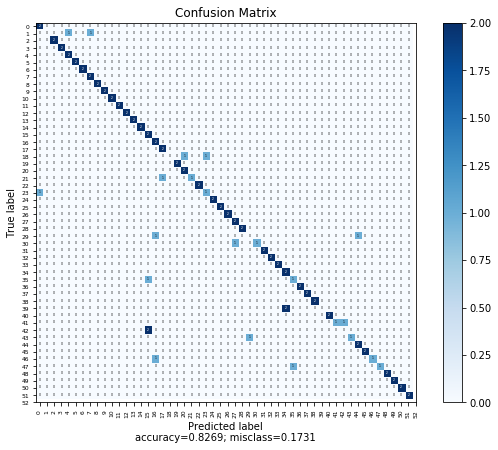

In [75]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


M = M_ideal
standard = False

D, N = X_train.shape
_step = 8
_card = 52

y_hat = []
rec_err = []



for i in range(_card):
    pca = PCA(n_comps=M, standard=standard)
    
    W_train = pca.fit(X_train[:,_step*i:_step*i+8])
    
    W_test = pca.transform(X_test)
    
    for k, (x, w) in enumerate(zip(X_test.T, W_test.T)):
    
        x_hat = pca.reconstruct(w.reshape(-1,1))
        
        _rec_err = np.linalg.norm(x_hat-(x.reshape(-1,1)))
        
        if len(y_hat) <= k:
            y_hat.append(int(i+1))
            rec_err.append(_rec_err)
        elif _rec_err < rec_err[k]:
            y_hat[k] = int(i+1)
            rec_err[k] = _rec_err

acc = accuracy_score(y_test.T, y_hat)    
print('M = ', M,' --->  Accuracy = %.2f%%' % (acc * 100))

cfn_matrix = confusion_matrix(y_test.T, y_hat)

class_names = np.arange(53)

plt.figure()

plot_confusion_matrix(cm           = cfn_matrix, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

plt.show()